<a href="https://colab.research.google.com/github/Amedeoxa/LAB2_project_group_N11/blob/main/Complete_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
# !pip install biopython

In [55]:
# !pip install aaindex

In [1]:
import requests
from requests.adapters import HTTPAdapter, Retry
import json
import re
import sys
import pandas as pd
from Bio import SeqIO
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import sklearn.metrics as skl
from sklearn.metrics import precision_recall_curve, confusion_matrix
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.SeqUtils import ProtParamData
from aaindex import aaindex1
import warnings
warnings.filterwarnings('ignore')

In [2]:
path_collection = './data_collection/'

In [3]:
url = "https://rest.uniprot.org/uniprotkb/search?format=json&query=%28%28fragment%3Afalse%29+AND+%28taxonomy_id%3A2759%29+AND+%28length%3A%5B40+TO+*%5D%29+AND+%28reviewed%3Atrue%29+AND+%28existence%3A1%29+AND+%28ft_signal_exp%3A*%29%29&size=500"
response = requests.get(url)
session = requests.Session()
print(f'The URL contains the query used to select the positive entries\nThe query is composed as follows:\n(fragment:false)\nAND (taxonomy_id:2759)\nAND (length:[40 TO *])\nAND (reviewed:true)\nAND (existence:1)\nAND (ft_signal_exp:*)')

The URL contains the query used to select the positive entries
The query is composed as follows:
(fragment:false)
AND (taxonomy_id:2759)
AND (length:[40 TO *])
AND (reviewed:true)
AND (existence:1)
AND (ft_signal_exp:*)


In [4]:
def get_next_link(headers):
    if "Link" in headers:
        links = headers["Link"].split(",")
        for link in links:
            match = re.search(r'<(.+)>; rel="next"', link)
            if match:
                return match.group(1)
    return None

def get_batch(batch_url):
    while batch_url:
        response = session.get(batch_url)
        response.raise_for_status()
        total = response.headers.get("x-total-results")
        yield response, total
        batch_url = get_next_link(response.headers)

In [5]:
def get_kingdom(entry):
  if "Fungi" in entry["organism"]["lineage"]:
     kd = "Fungi"
  elif "Viridiplantae" in entry["organism"]["lineage"]:
    kd = "Viridiplantae"
  elif "Metazoa" in entry["organism"]["lineage"]:
    kd = "Metazoa"
  else:
    kd = "Other"
  return kd

In [6]:
ok_entries = []
for response, total in get_batch(url):
    data = response.json()
    for i in range(len(data['results'])):
      entry = data['results'][i]
      if data['results'][i]['features'][0]['location']['end']['value'] > 13 and data['results'][i]['features'][0]['description'] == '':
        ok_entries.append(entry)
print('The total number of entries in the positive set is: ', len(ok_entries))

The total number of entries in the positive set is:  2932


In [7]:
with open(path_collection+"positive.tsv", 'w') as output_file, open(path_collection+"positive.fasta", "w") as fasta_outputfile:
  for entry in ok_entries:
    line = f'''{entry["primaryAccession"]}{'\t'}{entry["organism"]["scientificName"]}{'\t'}{get_kingdom(entry)}{'\t'}{entry["sequence"]["length"]}{'\t'}{entry["features"][0]["location"]["end"]["value"]}'''
    output_file.write(line + '\n')
    header = f""">{entry["primaryAccession"]} {entry["organism"]["scientificName"]}"""
    sequence = entry["sequence"]["value"]
    fasta_outputfile.write(header + "\n" + sequence + "\n")

# Negatives

In [8]:
urlo_neg = "https://rest.uniprot.org/uniprotkb/search?format=json&query=%28%28fragment%3Afalse%29+AND+%28taxonomy_id%3A2759%29+AND+%28length%3A%5B40+TO+*%5D%29+AND+%28reviewed%3Atrue%29+AND+%28existence%3A1%29+NOT+%28ft_signal%3A*%29+OR+%28cc_scl_term_exp%3ASL-0091%29+OR+%28cc_scl_term_exp%3ASL-0191%29+OR+%28cc_scl_term_exp%3ASL-0173%29+OR+%28cc_scl_term_exp%3ASL-0209%29+OR+%28cc_scl_term_exp%3ASL-0204%29+OR+%28cc_scl_term_exp%3ASL-0039%29%29&size=500"
response_neg = requests.get(urlo_neg)
session = requests.Session()
print(f'The URL contains the query used to select the negative entries\nThe query is composed as follows:\n(fragment:false)\nAND (taxonomy_id:2759)\nAND (length:[40 TO *])\nAND (reviewed:true)\nAND (existence:1)\nNOT (ft_signal:*)\nOR (cc_scl_term_exp:SL-0091)\nOR (cc_scl_term_exp:SL-0191)\nOR (cc_scl_term_exp:SL-0173)\nOR (cc_scl_term_exp:SL-0209)\nOR (cc_scl_term_exp:SL-0204)\nOR (cc_scl_term_exp:SL-0039)')

The URL contains the query used to select the negative entries
The query is composed as follows:
(fragment:false)
AND (taxonomy_id:2759)
AND (length:[40 TO *])
AND (reviewed:true)
AND (existence:1)
NOT (ft_signal:*)
OR (cc_scl_term_exp:SL-0091)
OR (cc_scl_term_exp:SL-0191)
OR (cc_scl_term_exp:SL-0173)
OR (cc_scl_term_exp:SL-0209)
OR (cc_scl_term_exp:SL-0204)
OR (cc_scl_term_exp:SL-0039)


In [9]:
neg_entries = []
count = 0
for response, total in get_batch(urlo_neg):
    data_neg = response.json()
    for i in range(len(data_neg['results'])):
      entry_neg = data_neg['results'][i]
      tm_present = False  # Initialize the boolean flag for this entry
      # Iterate through the features list for each entry
      for feature in entry_neg.get('features', []):
          # Check if the 'type' key exists and is 'Transmembrane'
          if feature.get('type') == 'Transmembrane':
              if feature.get("description") == "Helical":
                if feature.get("location", {}).get("start", {}).get("value", float('inf')) <= 90:
                  tm_present = True
                  count += 1
                  break # Found the specific TM domain, no need to check further features for this entry

      # Append the entry data along with the tm_present flag
      # This ensures that the boolean corresponds to the entry
      neg_entries.append((entry_neg, tm_present))
print('The number of proteins having the transmembrane helix in the first 90 residues is: ', count)
print('The total number of entries in the negative set is: ', len(neg_entries))

The number of proteins having the transmembrane helix in the first 90 residues is:  1384
The total number of entries in the negative set is:  20615


In [10]:
with open(path_collection+"negative.tsv", 'w') as output_file, open(path_collection+"negative.fasta", "w") as fasta_outputfile:
  for i, entry in enumerate(neg_entries):
    line = f'''{entry[0]["primaryAccession"]}{'\t'}{entry[0]["organism"]["scientificName"]}{'\t'}{get_kingdom(entry[0])}{'\t'}{entry[0]["sequence"]["length"]}{'\t'}{entry[1]}'''
    output_file.write(line + '\n')
    header = f""">{entry[0]["primaryAccession"]} {entry[0]["organism"]["scientificName"]}"""
    sequence = entry[0]["sequence"]["value"]
    fasta_outputfile.write(header + "\n" + sequence + "\n")

In [11]:
path_clusters = './data_preparation/clusters/'

## Commands used to group sequences into clusters where every member sequence aligns to the cluster representative with at least 30% identity and the alignment covers at least 40% of the longer sequence.
### Using MMseqs2:
```
mmseqs easy-cluster positive.fasta ./data_preparation/clusters/cluster-results tmp --min-seq-id 0.3 -c 0.4 --cov-mode 0 --cluster-mod
mmseqs easy-cluster negative.fasta ./data_preparation/clusters/cluster-results-neg tmp --min-seq-id 0.3 -c 0.4 --cov-mode 0 --cluster-mode
```

## Command to retrieve the unique representative sequence IDs
### Using bash uniq
```
cut -f 1 cluster-results_cluster.tsv | uniq > uniq.pos.tsv
cut -f 1 cluster-results-neg_cluster.tsv | uniq > uniq.neg.tsv
```

In [ ]:
# NOTE MISSING EXTERNAL TOOLS: uniq , cluster
# NOTE UPDATE: da cancellare, questo mi serviva solo per per integrare mmseqs2 sul mio pc che ha una distro immutibile. per linux normale e' molto piu' semmplice aggiungere il commando mmseqs2
import subprocess
import sys
import os

def run_cluster(input_file, out_file, out_dir, temp_dir):

    # The full list of arguments for the mmseqs command
    command = [
        "mmseqs", 
        "easy-cluster",
        input_file,
        out_dir + out_file,
        temp_dir,
        "--min-seq-id", "0.3",
        "-c", "0.4",
        "--cov-mode", "0",
        "--cluster-mode", "0"  # Assuming cluster-mode 0 (default) or you meant to specify an integer
    ]

    try:
        # Create the temporary directory if it doesn't exist
        os.makedirs(temp_dir, exist_ok=True)
        
        # Execute the command
        result = subprocess.run(
            command,
            capture_output=True,
            text=True,
            check=True  # Raise an exception if the command fails
        )
        
        print("MMseqs2 command successful.")
        print(f"Stdout:\n{result.stdout}")
        # Stderr will often contain MMseqs2 status updates
        # print(f"Stderr:\n{result.stderr}") 

    except subprocess.CalledProcessError as e:
        print(f"--- ERROR: MMseqs2 failed for {input_file} ---")
        print(f"Return Code: {e.returncode}")
        print(f"Stdout (partial output):\n{e.stdout}")
        print(f"Stderr (error message):\n{e.stderr}")
        sys.exit(1) # Exit the script upon failure
    except FileNotFoundError:
        print("Error: 'mmseqs' command not found. Ensure MMseqs2 is installed and in your system PATH.")
        sys.exit(1)
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        sys.exit(1)

#cluster positive sequences
run_cluster(input_file=path_collection+'positive.fasta', out_file='testcluster-results', out_dir=path_clusters, temp_dir='temp_dir')

#cluster negative sequences
run_cluster(input_file=path_collection+'negative.fasta', out_file='testcluster-results-neg', out_dir=path_clusters,  temp_dir='temp_dir')
        

In [13]:
path_non_redun = './data_preparation/non_redundant/'

In [14]:
def filter_redundancy(unique_ids, total_dataset):

    unique_ids = pd.read_csv(unique_ids, header=None, sep='\t')
    total_df = pd.read_csv(total_dataset, header=None, sep='\t')
    filtered = total_df[total_df.iloc[:,0].isin(unique_ids.iloc[:,0])]
    return filtered

non_redundant_pos = filter_redundancy(path_non_redun+'uniq.pos.tsv', path_collection+'positive.tsv')
non_redundant_neg = filter_redundancy(path_non_redun+'uniq.neg.tsv', path_collection+'negative.tsv')
print(f'The number of unique positive entries: {len(non_redundant_neg)}')
print(f'The number of unique negative entries: {len(non_redundant_pos)}')

The number of unique positive entries: 8934
The number of unique negative entries: 1093


In [32]:
#Dividing in train and test set
def split_train_test(df: pd.DataFrame, split: int):
    random_seed = 42
    shuffle_df = df.sample(frac=1, random_state=random_seed)
    split_idx = split*len(df.index)//100
    training_set = shuffle_df.iloc[:split_idx,:].copy()
    test_set = shuffle_df.iloc[split_idx:,:].copy()
    return training_set, test_set

training_set_pos, test_set_pos = split_train_test(non_redundant_pos, 80)
training_set_neg, test_set_neg = split_train_test(non_redundant_neg, 80)




print(f'the lenght of the positive set is {len(training_set_pos)+len(test_set_pos)}; training: {len(training_set_pos)}, testing: {len(test_set_pos)}')
print(f'the lenght of the negative set is {len(training_set_neg)+len(test_set_neg)}; training: {len(training_set_neg)}, testing: {len(test_set_neg)}')

#Dividing the training set in 5 validation sets
bins = [0, 25, 50, 75, 100]
bin_lables = [1, 2, 3, 4, 5]
training_set_pos.loc[:, 'temp_row_num'] = training_set_pos.index.to_numpy(dtype=np.int64)

training_set_pos.loc[:, 'validation_n'] = pd.qcut(training_set_pos['temp_row_num'], q=5 , labels=bin_lables )

training_set_neg.loc[:, 'temp_row_num'] = training_set_neg.index.to_numpy(dtype=np.int64)

training_set_neg.loc[:, 'validation_n'] = pd.qcut(training_set_neg['temp_row_num'], q=5 , labels=bin_lables )

training_set_pos = training_set_pos.drop(columns=['temp_row_num'])
training_set_neg = training_set_neg.drop(columns=['temp_row_num'])

training_set_pos["sp_type"] = 1
training_set_neg["sp_type"] = 0

training_set = pd.concat([training_set_pos, training_set_neg])
test_set = pd.concat([test_set_pos, test_set_neg])

# NOTE update PATH
training_set_pos.to_csv('training_set_pos.tsv', sep='\t', index=False, header=False)
test_set_pos.to_csv('test_set_pos.tsv', sep='\t', index=False, header=False)

training_set_neg.to_csv('training_set_neg.tsv', sep='\t', index=False, header=False)
test_set_neg.to_csv('test_set_neg.tsv', sep='\t', index=False, header=False)

training_set.to_csv('training_set.tsv', sep='\t', index=False, header=False)
test_set.to_csv('test_set.tsv', sep='\t', index=False, header=False)



the lenght of the positive set is 1093; training: 874, testing: 219
the lenght of the negative set is 8934; training: 7147, testing: 1787


In [15]:
path_sets = './data_preparation/sets/'

In [16]:
#Data analysis
#Training set

neg_cols = ['ID', 'Organism_name', 'Kingdom', 'Sequence_length', 'Transmembrane']
negatives_train = pd.read_csv(path_sets + 'training_set_neg.tsv', sep='\t', names=neg_cols)
negatives_test = pd.read_csv(path_sets + 'test_set_neg.tsv', sep='\t', names=neg_cols)


pos_cols = ['ID', 'Organism_name', 'Kingdom', 'Sequence_length', 'Signal_peptide']
positives_train = pd.read_csv(path_sets + 'training_set_pos.tsv', sep='\t', names=pos_cols)
positives_test = pd.read_csv(path_sets + 'test_set_pos.tsv', sep='\t', names=pos_cols)

#Comparison between sequence length in positive and negative entries

negatives_train['Log_seq_len'] = np.log10(negatives_train['Sequence_length'])
positives_train['Log_seq_len'] = np.log10(positives_train['Sequence_length'])
positives_test['Log_seq_len'] = np.log10(positives_test['Sequence_length'])
negatives_test['Log_seq_len'] = np.log10(negatives_test['Sequence_length'])


negatives_train["Source"] = "negatives"
positives_train["Source"] = "positives"
training = pd.concat([negatives_train[['Log_seq_len', 'Source']], positives_train[['Log_seq_len', 'Source']]], ignore_index=True)
negatives_test["Source"] = "negatives"
positives_test["Source"] = "positives"
test = pd.concat([negatives_test[['Log_seq_len', 'Source']], positives_test[['Log_seq_len', 'Source']]], ignore_index=True)

#Comparison of the amminoacid composition of SPs between our dataset and SwissProt data

records = SeqIO.parse(path_clusters + "cluster-results_rep_seq.fasta", "fasta")
data = {
    "id": [],
    "sequence": []
}
for record in records:
    data["id"].append(record.id)
    data["sequence"].append(str(record.seq))
pos_seqs = pd.DataFrame(data)


new_pos_train = pos_seqs.merge(positives_train[['ID','Signal_peptide']], how='inner', left_on='id', right_on='ID')
new_pos_train = new_pos_train.drop(columns=['ID'])

new_pos_test = pos_seqs.merge(positives_test[['ID','Signal_peptide']], how='inner', left_on='id', right_on='ID')
new_pos_test = new_pos_test.drop(columns=['ID'])


swiss_freq = {
    'A': 8.25, 'Q': 3.93, 'L': 9.64, 'S': 6.65,
    'R': 5.52, 'E': 6.71, 'K': 5.79, 'T': 5.36,
    'N': 4.06, 'G': 7.07, 'M': 2.41, 'W': 1.10,
    'D': 5.46, 'H': 2.27, 'F': 3.86, 'Y': 2.92,
    'C': 1.38, 'I': 5.90, 'P': 4.74, 'V': 6.85
}

swiss_freq = {k: v / 100 for k, v in swiss_freq.items()}

In [17]:
swiss_freq = {
    'A': 8.25, 'Q': 3.93, 'L': 9.64, 'S': 6.65,
    'R': 5.52, 'E': 6.71, 'K': 5.79, 'T': 5.36,
    'N': 4.06, 'G': 7.07, 'M': 2.41, 'W': 1.10,
    'D': 5.46, 'H': 2.27, 'F': 3.86, 'Y': 2.92,
    'C': 1.38, 'I': 5.90, 'P': 4.74, 'V': 6.85
}

swiss_freq = {k: v / 100 for k, v in swiss_freq.items()}

In [18]:
print(swiss_freq)

{'A': 0.0825, 'Q': 0.0393, 'L': 0.0964, 'S': 0.0665, 'R': 0.0552, 'E': 0.06709999999999999, 'K': 0.0579, 'T': 0.0536, 'N': 0.0406, 'G': 0.0707, 'M': 0.0241, 'W': 0.011000000000000001, 'D': 0.0546, 'H': 0.0227, 'F': 0.038599999999999995, 'Y': 0.0292, 'C': 0.0138, 'I': 0.059000000000000004, 'P': 0.047400000000000005, 'V': 0.06849999999999999}


In [20]:
def fasta_to_dataframe(fasta_file, second_fasta):
  records = SeqIO.parse(fasta_file, "fasta")
  records2 = SeqIO.parse(second_fasta, "fasta")
  data = {
      "id": [],
      "sequence": []
  }
  for record in records:
      data["id"].append(record.id)
      data["sequence"].append(str(record.seq))
  for record in records2:
      data["id"].append(record.id)
      data["sequence"].append(str(record.seq))
  seqs_df = pd.DataFrame(data)
  return seqs_df

seqs_df = fasta_to_dataframe(path_clusters + "cluster-results-neg_rep_seq.fasta", path_clusters +"cluster-results_rep_seq.fasta")
seqs_df.head()

,id,sequence
0,P41252,MLQQVPENINFPAEEEKILEFWTEFNCFQECLKQSKHKPKFTFYDG...
1,Q01064,MELSPRSPPEMLEESDCPSPLELKSAPSKKMWIKLRSLLRYMVKQL...
2,Q0IIM8,MWLKPEEVLLKNALKLWLMERSNDYFVLQRRRGYGEEGGGGLTGLL...
3,Q0VDF9,MAAIGVHLGCTSACVAVYKDGRAGVVANDAGDRVTPAVVAYSENEE...
4,Q5VWZ2,MAAASGSVLQRCIVSPAGRHSASLIFLHGSGDSGQGLRMWIKQVLN...


In [21]:
cols = ["id", "organism_name", "kingdom","seq_len","SP","validation_n", "sp_type"]
training_df = pd.read_csv(path_sets + "training_set.tsv", sep="\t", names= cols)
training_df.head()

,id,organism_name,kingdom,seq_len,SP,validation_n,sp_type
0,Q99MA2,Rattus norvegicus,Metazoa,674,22,3,1
1,P17948,Homo sapiens,Metazoa,1338,26,1,1
2,P41271,Homo sapiens,Metazoa,181,16,1,1
3,Q8I948,Acanthoscurria gomesiana,Metazoa,156,23,4,1
4,Q92154,Coturnix japonica,Metazoa,620,17,4,1


In [22]:
complete_train = training_df.merge(seqs_df, on="id", how="inner")
complete_train.tail()

,id,organism_name,kingdom,seq_len,SP,validation_n,sp_type,sequence
8016,Q01981,Emericella nidulans (strain FGSC A4 / ATCC 381...,Fungi,416,0,4,0,MPQPGSSVDFSNLLNPQNNTAIPAEVSNATASATMASGASLLPPMV...
8017,Q9H3N8,Homo sapiens,Metazoa,390,0,1,0,MPDTNSTINLSLSTRVTLAFFMSLVAFAIMLGNALVILAFVVDKNL...
8018,P32349,Saccharomyces cerevisiae (strain ATCC 204508 /...,Fungi,654,0,3,0,MDELLGEALSAENQTGESTVESEKLVTPEDVMTISSLEQRTLNPDL...
8019,G5EGE9,Caenorhabditis elegans,Metazoa,1263,0,3,0,MDVPSSSNVTGRRKRQVLDDDEDDGFRSTPLRKVRGTKKIRPADVV...
8020,Q95339,Sus scrofa,Metazoa,88,1,5,0,MASVVPLKDRRLLEVKLGELPSWILMRDFTPSGIAGAFQRGYYRYY...


In [26]:
#NOTE complete train in che dir va ? 
complete_train.to_csv("complete_train.tsv", sep='\t', index=False)


In [23]:
# func to make permutations of 5 groups with e taining sets, 1 test set, 1 validation set 
def make_groups():
    l = [_ for _ in range(5)]
    group = {}
    for i in l:
        print(f'{(i%5)+1} {((i+1)%5)+1} {((i+2)%5)+1} {((i+3)%5)+1} {((i+4)%5)+1}')
        train = (((i%5)+1 ,((i+1)%5)+1 ,((i+2)%5)+1))
        test = ((i+3)%5)+1
        cross_val = ((i+4)%5)+1
        name_test = f'test_{i+1}'
        group[name_test] = (train, test, cross_val)
    return group

groups = make_groups()

1 2 3 4 5
2 3 4 5 1
3 4 5 1 2
4 5 1 2 3
5 1 2 3 4


In [24]:
order = list("ARNDCQEGHILKMFPSTWYV")
PSWM = np.ones((15,20))

aa_index = {}
for i, aa in enumerate(order):
  aa_index[aa]= i

print(aa_index)

{'A': 0, 'R': 1, 'N': 2, 'D': 3, 'C': 4, 'Q': 5, 'E': 6, 'G': 7, 'H': 8, 'I': 9, 'L': 10, 'K': 11, 'M': 12, 'F': 13, 'P': 14, 'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19}


In [25]:
# NOTE check comment 
# init the matrix for vonHeijne to 1s. add freq count for each aa
def vonHeijne_matrix(sequences, window:int):
  order = list("ARNDCQEGHILKMFPSTWYV")
  PSWM = np.ones((15,20))
  aa_index = {}
  for i, aa in enumerate(order):
    aa_index[aa]= i
  PSPM_final = np.ones((window,20))

  for record in sequences['sp_cut']:
    temp_matrix = np.zeros((window,20))
    for i, aa in enumerate(record):
      if aa in aa_index:
        col = aa_index[aa]
        temp_matrix[i][col] += 1

    PSPM_final += temp_matrix
  return PSPM_final

In [26]:
def calculus(PSPM_final, sequences, swiss_freq):
  PSWM = PSPM_final/(len(sequences) +20)
  #Divide all the counts by the corresponding residue frequency in the SwissProtbackground distribution
  for key , val in aa_index.items():
    PSWM[:,val] /= swiss_freq[key]
  #log
  log_odds = np.log(PSWM)
  return log_odds, PSWM

In [27]:
def full_pipeline(sequences, window:int, swiss_freq):
  PSPM_final = vonHeijne_matrix(sequences, window)
  log_odds, PSWM = calculus(PSPM_final, sequences, swiss_freq)
  return log_odds, PSWM, PSPM_final

np.set_printoptions(edgeitems=10, linewidth=400)

In [28]:
def best_score_calculator(sequence, n_residues: int, window: int, PSWM, aa_index):
  sequence_scores = []
  for i in range(n_residues-window+1):
    window_seq = sequence[i:i+window]
    score = 0
    for j, aa in enumerate(window_seq):
      if aa in aa_index:
        score += PSWM[j, aa_index[aa]]
    sequence_scores.append(float(score))
  return max(sequence_scores)

In [29]:
def cut_sp_sequence(row):
    return str(row['sequence'])[(row['SP']-13):(row['SP']+2)]

In [30]:
def training_vonHeijne(training_set, train):
  tr_set = training_set[training_set['validation_n'].isin(train)]
  tr_set = tr_set.loc[tr_set["sp_type"]==1]
  tr_set['sp_cut'] = tr_set.apply(cut_sp_sequence, axis=1)
  log_odds, PSWM, PSPM_final = full_pipeline(tr_set, 15, swiss_freq)
  return log_odds

In [31]:
def score_vonHeijne(dataset, pswm, aa_index):
  score = []
  for seq in dataset["sequence"]:
      seq_score = best_score_calculator(seq, 90, 15, pswm, aa_index)
      score.append(round(seq_score,3))
  return score

In [32]:
def validation_vonHeijne(training_set, validation, log_odds, aa_index):
  validation_set = training_set[training_set['validation_n'] == validation]
  validation_scores = score_vonHeijne(validation_set, log_odds, aa_index)
  y_validation = validation_set["sp_type"].to_list()
  precision, recall, thresholds = precision_recall_curve(y_validation, validation_scores)
  fscore = (2 * precision * recall) / (precision + recall)
  index = np.argmax(fscore)
  optimal_threshold = thresholds[index]
  return optimal_threshold, validation_scores, y_validation

In [33]:
def test_vonHeijne(training_set, test, optimal_threshold, log_odds, aa_index):
  test_set = training_set[training_set['validation_n'] == test]
  test_scores = score_vonHeijne(test_set, log_odds, aa_index)
  y_pred_test = [int(t_s >= optimal_threshold) for t_s in test_scores]
  obs_test = test_set["sp_type"].to_list()
  return y_pred_test, obs_test

In [34]:
def metrics(obs_test, y_pred_test):
  MCC = skl.matthews_corrcoef(obs_test, y_pred_test)            # Matthews Correlation Coefficient
  ACC = skl.accuracy_score(obs_test, y_pred_test)               # Accuracy
  PPV = skl.precision_score(obs_test, y_pred_test)              # Precision
  SEN = skl.recall_score(obs_test, y_pred_test)                 # Recall
  CONF =skl.confusion_matrix(obs_test , y_pred_test)            # Confusion Matrix
  return MCC, ACC, PPV, SEN, CONF

In [35]:
def plot_pr_and_confusion(y_true, y_scores, y_test, y_pred_test, optimal_threshold=None, labels=None, run_id = None):
    fig, axes = plt.subplots(1, 2, figsize=(12,5))

    # --- 1. Precision–Recall Curve ---
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    axes[0].plot(recall, precision, marker=".", label="PR curve")
    if optimal_threshold is not None:
        idx = (np.abs(thresholds - optimal_threshold)).argmin()
        axes[0].scatter(recall[idx], precision[idx], color="red", s=80,
                        label=f"Threshold={optimal_threshold:.2f}")
    axes[0].set_xlabel("Recall")
    axes[0].set_ylabel("Precision")
    axes[0].set_title("Precision–Recall curve")
    axes[0].legend()
    axes[0].grid(True)

    # --- 2. Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred_test, labels=labels)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels, cbar=False, ax=axes[1])
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("True")
    axes[1].set_title("Confusion Matrix")

    plt.tight_layout()
    suffix = f"_{run_id}" if run_id is not None else ""
    filename = f"pr_and_confusion{suffix}.png"
    plt.savefig(filename)
    plt.show()


((1, 2, 3), 4, 5)


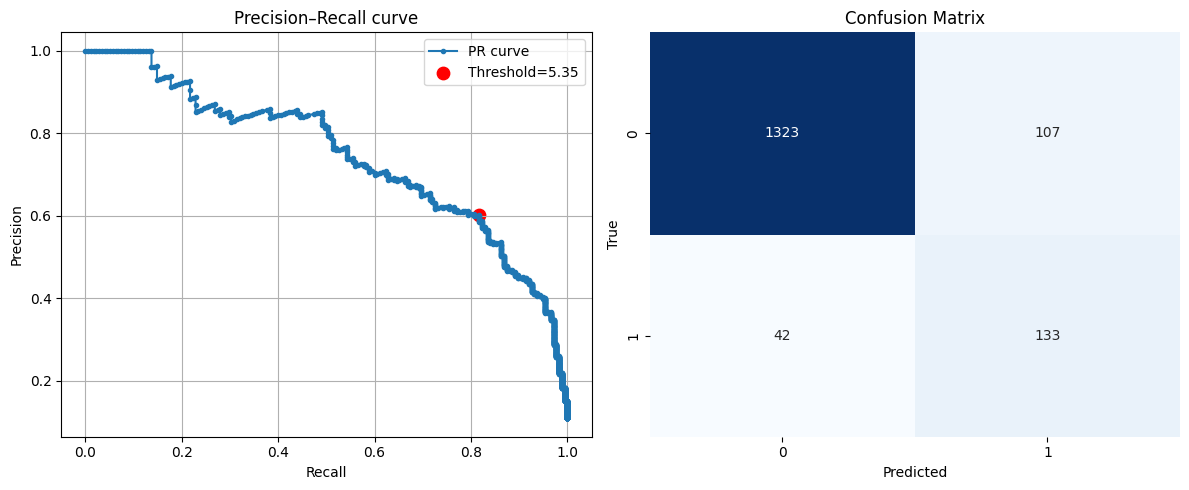

((2, 3, 4), 5, 1)


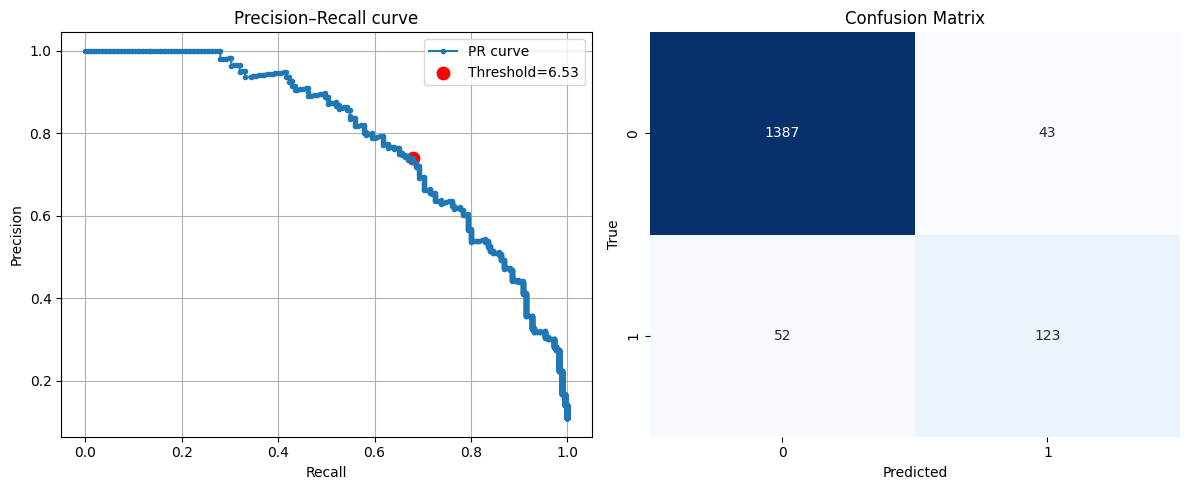

((3, 4, 5), 1, 2)


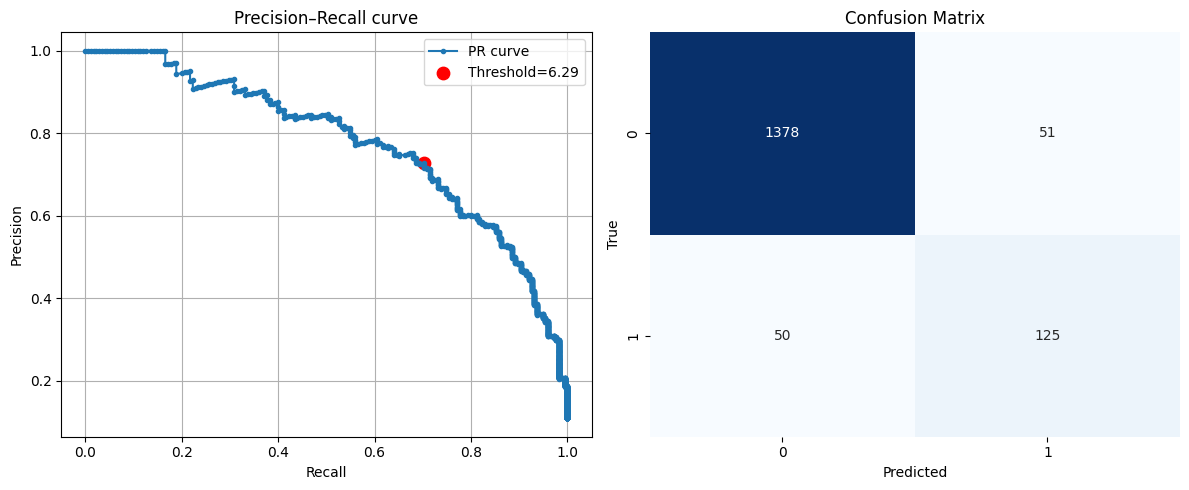

((4, 5, 1), 2, 3)


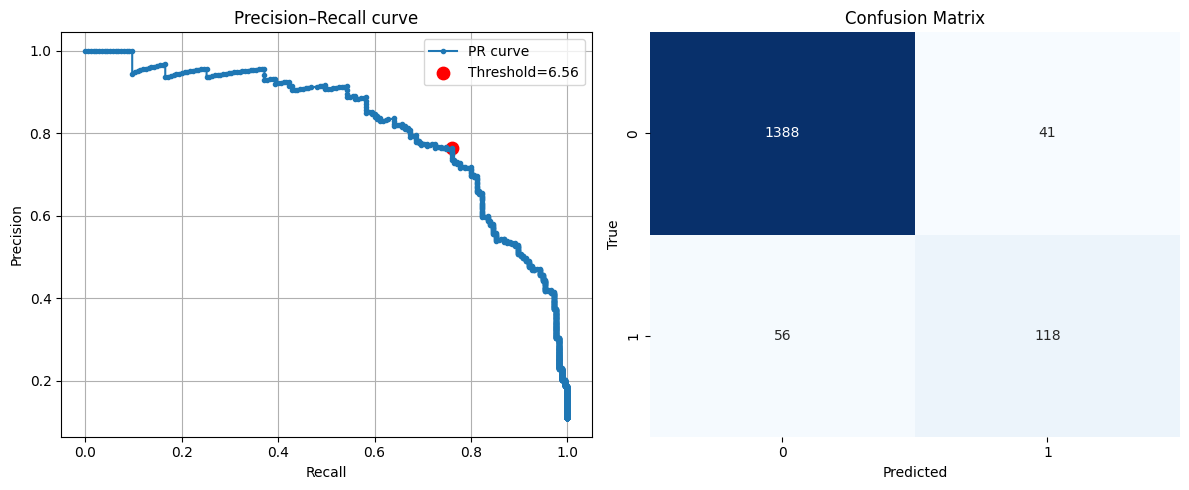

((5, 1, 2), 3, 4)


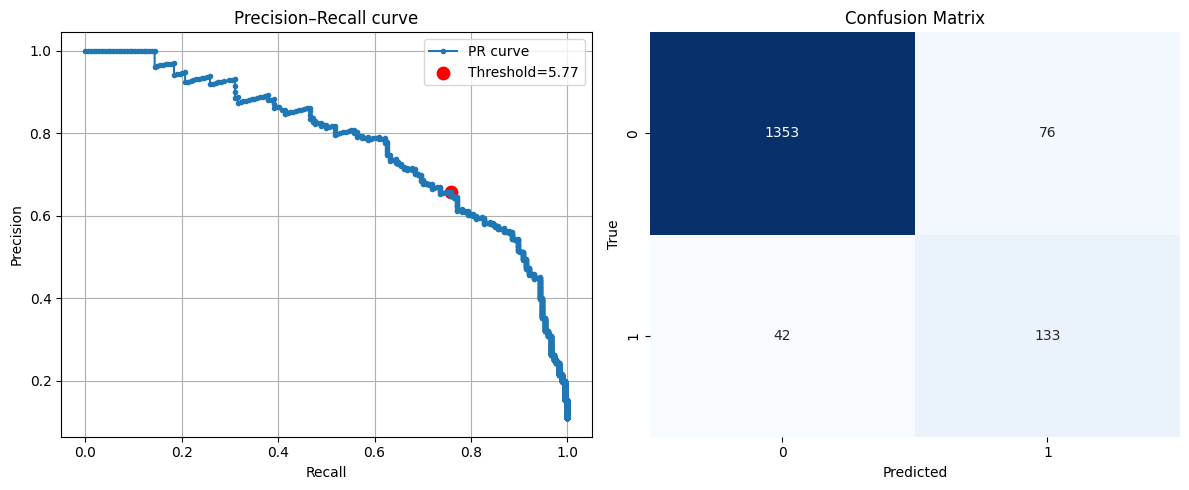

The average of the performance metrics are
        MCC       ACC       PPV       SEN  threshold
0  0.658971  0.930186  0.676772  0.723061        6.1


In [38]:
#NOTE bisognerebbe indicare ogni grafico a chi appartiene , magari nel titolo ? 
all_metrics = []
for key, value in groups.items():
    train, validation, test = value
    print(value) # permutation group 
    log_odds = training_vonHeijne(complete_train, train)
    optimal_threshold, validation_scores, y_validation = validation_vonHeijne(complete_train, validation, log_odds, aa_index)
    y_pred_test, obs_test = test_vonHeijne(complete_train, test, optimal_threshold, log_odds, aa_index)

    MCC, ACC, PPV, SEN, CONF = metrics(obs_test, y_pred_test)
    all_metrics.append([MCC, ACC, PPV, SEN, optimal_threshold])
    plot_pr_and_confusion(
    y_validation,
    validation_scores,
    obs_test,
    y_pred_test,
    optimal_threshold,
    labels=[0,1],
    run_id=key
    )
avg_metrics = np.mean(np.array(all_metrics), axis=0)
means = pd.DataFrame([avg_metrics], columns=['MCC', 'ACC', 'PPV', 'SEN', 'threshold'])
print(f'The average of the performance metrics are\n{means}')

In [39]:
complete_train.head()

,id,organism_name,kingdom,seq_len,SP,validation_n,sp_type,sequence
0,Q99MA2,Rattus norvegicus,Metazoa,674,22,3,1,MAQAYWQCYPWLVLLCACAWSYPGPESLGREDVRDCSTNPPRLPVT...
1,P17948,Homo sapiens,Metazoa,1338,26,1,1,MVSYWDTGVLLCALLSCLLLTGSSSGSKLKDPELSLKGTQHIMQAG...
2,P41271,Homo sapiens,Metazoa,181,16,1,1,MMLRVLVGAVLPAMLLAAPPPINKLALFPDKSAWCEAKNITQIVGH...
3,Q8I948,Acanthoscurria gomesiana,Metazoa,156,23,4,1,MAFRMKLVVCIVLLSTLAVMSSADVYKGGGGGRYGGGRYGGGGGYG...
4,Q92154,Coturnix japonica,Metazoa,620,17,4,1,MELLVLTVLLMGTGCISAPWAAWMPPKMAALSGTCVQLPCRFDYPE...


In [40]:
def aa_composition(sequence, length: int, aa_index):
  sequence = sequence[:length]
  freq = np.zeros((1, 20))
  for aa in sequence:
    if aa in aa_index.keys():
      freq[0, aa_index[aa]] += 1
  freq = np.round(freq/len(sequence), 3)
  return freq

aa_comp = np.vstack(complete_train['sequence'].apply(aa_composition, args=(22, aa_index)))
aa_comp

array([[0.182, 0.   , 0.   , ..., 0.136, 0.136, 0.045],
       [0.045, 0.   , 0.   , ..., 0.045, 0.045, 0.091],
       [0.182, 0.045, 0.   , ..., 0.   , 0.   , 0.136],
       ...,
       [0.091, 0.   , 0.045, ..., 0.   , 0.   , 0.045],
       [0.   , 0.136, 0.045, ..., 0.   , 0.   , 0.136],
       [0.045, 0.091, 0.   , ..., 0.   , 0.   , 0.136]], shape=(8021, 20))

In [49]:
%%capture 
# ^ used to silence the warining ouput refering to X not being a standard aa 
def hydrophobicity(sequence, window: int, length: int):
    sequence = sequence[:length]
    seq = ProteinAnalysis(sequence)
    kd_pos = seq.protein_scale(ProtParamData.kd,window)
    d = int(window/2)
    sequence_with_padding = "X"*d + sequence + "X"*d
    seq_padding = ProteinAnalysis(sequence_with_padding)
    kd_pos_with_padding = seq_padding.protein_scale(ProtParamData.kd, window)
    return kd_pos_with_padding

hydro = np.vstack(complete_train['sequence'].apply(hydrophobicity, args=(5,40)))

In [50]:
print(hydro.shape)

(8021, 40)


In [52]:
%%capture
# ^ used to silence the warining ouput refering to X not being a standard aa 
feature_codes = {
    "net_charge": ("KLEP840101", 2),
    "hydrophilicity": ("HOPT810101", 5),
    "helix_propensity": ("CHAM830101",7),
    "flexibility": ("BHAR880101", 7),
    "isoelectric_point": ("ZIMJ680104", 2),
    "bulkiness": ("ZIMJ680102", 7)
}

def features(sequence, length: int, feature_code, window: int):
  sequence = sequence[:length]
  seq = ProteinAnalysis(sequence)
  vals = aaindex1[feature_code].values
  val = seq.protein_scale(vals,window)
  mean = np.mean(val)
  std = np.std(val)
  max = np.max(val)
  return np.round([mean, std, max], 3)

feats = {}
for feature in feature_codes.keys():
  feats[feature] = np.vstack(complete_train['sequence'].apply(features, args=(30, feature_codes[feature][0], feature_codes[feature][1])))

# NOTE questo dove lo salviamo ? 
np.savez('separate_features.npz', aa_comp = aa_comp, hydrophobicity = hydro, **feats)

In [53]:
loaded_separate_data = np.load('separate_features.npz')

# Access the feature matrices and target vector using their keys
loaded_aacomp = loaded_separate_data['aa_comp']
print(loaded_aacomp.shape)

(8021, 20)
